[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sacha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




=== Modèle SVM ===


c:\Users\Sacha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.79      0.82      0.81       250
           1       0.78      0.74      0.76       210

    accuracy                           0.78       460
   macro avg       0.78      0.78      0.78       460
weighted avg       0.78      0.78      0.78       460



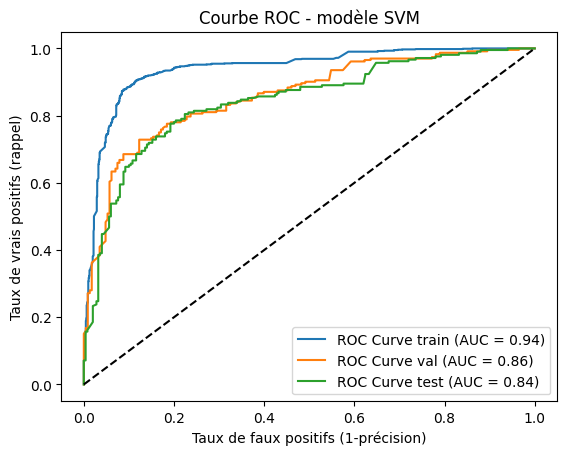

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# Préparation des données
nltk.download('stopwords')
french_stopwords = stopwords.words('french')

# Chargement des données
data_file = 'global_table.tsv'
df = pd.read_csv(data_file, sep="\t")
df = df.dropna(subset=['text', 'speaker'])

# Regroupement et nettoyage des données
df.loc[(df['speaker'] == 'patient_1') | (df['speaker'] == 'patient_2'), 'speaker'] = 'patient'
df['text'] = df['text'].apply(lambda text: re.sub(r'\d+', '', re.sub(r'[^\w\s]', '', text.lower())))

# Division en trois ensembles : entraînement, validation, test
x = df['text']
y = df['speaker']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3,random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,random_state=1)


# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words=french_stopwords)
x_train_tfidf = tfidf.fit_transform(x_train)
x_val_tfidf = tfidf.transform(x_val)
x_test_tfidf = tfidf.transform(x_test)


print(f'\n\n=== Modèle SVM ===')

model=SVC(kernel="linear",C=1)
model.fit(x_train_tfidf, label_binarize(y_train,classes=["medecin","patient"]))
y_test_pred = model.predict(x_test_tfidf)
print(classification_report(label_binarize(y_test,classes=["medecin","patient"]), y_test_pred))


y_scores_val = model.decision_function(x_val_tfidf)
y_scores_train = model.decision_function(x_train_tfidf)
y_scores_test = model.decision_function(x_test_tfidf)

# Calculer la courbe ROC
fpr_train, tpr_fpr_train, thresholds_train = roc_curve(label_binarize(y_train,classes=["medecin","patient"]), y_scores_train)
auc_score_train = roc_auc_score(label_binarize(y_train,classes=["medecin","patient"]), y_scores_train)

# Calculer la courbe ROC
fpr_val, tpr_fpr_val, thresholds_val = roc_curve(label_binarize(y_val,classes=["medecin","patient"]), y_scores_val)
auc_score_val = roc_auc_score(label_binarize(y_val,classes=["medecin","patient"]), y_scores_val)


# Calculer la courbe ROC
fpr_test, tpr_fpr_test, thresholds_test = roc_curve(label_binarize(y_test,classes=["medecin","patient"]), y_scores_test)
auc_score_test = roc_auc_score(label_binarize(y_test,classes=["medecin","patient"]), y_scores_test)


# Tracer la courbe ROC
plt.plot(fpr_train, tpr_fpr_train, label=f'ROC Curve train (AUC = {auc_score_train:.2f})')
plt.plot(fpr_val, tpr_fpr_val, label=f'ROC Curve val (AUC = {auc_score_val:.2f})')
plt.plot(fpr_test, tpr_fpr_test, label=f'ROC Curve test (AUC = {auc_score_test:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Ligne de référence
plt.xlabel('Taux de faux positifs (1-précision)')
plt.ylabel('Taux de vrais positifs (rappel)')
plt.title('Courbe ROC - modèle SVM')
plt.legend()
plt.show()







=== Modèle SVM ===
              precision    recall  f1-score   support

     medecin       0.76      0.87      0.81       228
     patient       0.85      0.73      0.78       232

    accuracy                           0.80       460
   macro avg       0.80      0.80      0.80       460
weighted avg       0.80      0.80      0.80       460



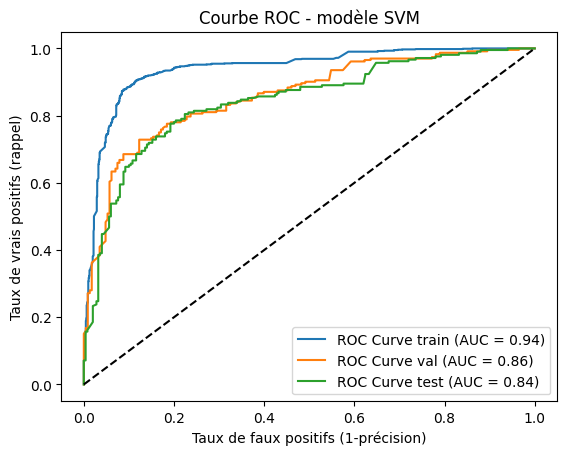

In [3]:

     
    #   {"name":"Multi NB",
    #   "estimator":MultinomialNB(),
    #   "params_grid":{'alpha':[0.1,0.3,0.5]}
    # }

    # {"name":"SVM",
    #  "estimator":SVC(random_state=42),
    #  "params_grid":{'C': [0.01,0.1, 1, 10, 100],'kernel':["linear","poly","rbf","sigmoid"]}
    # },

    # {"name":"RandomForest",
    #   "estimator":RandomForestClassifier(random_state=42),
    #   "params_grid":{'n_estimators': [100, 200, 500], 'max_depth': [10,50,None],'max_features':['sqrt','log2',None]}
    # },


# for model in models_noparam:

#     print(f'\n\n=== Modèle {model} ===')


#     model.fit(x_train_tfidf, label_binarize(y_train,classes=["medecin","patient"]))

#     y_val_pred = model.predict(x_val_tfidf)
#     print(classification_report(label_binarize(y_val,classes=["medecin","patient"]), y_val_pred))

# for model in models_to_evaluate:

#     print(f'\n\n=== Modèle {model["name"]} ===')

#     grid_search = GridSearchCV(model["estimator"],model["params_grid"], cv=5)
#     grid_search.fit(x_train_tfidf, y_train)

#     best = grid_search.best_estimator_

#     print(f"Meilleur hyperparamètres : {grid_search.best_params_}")
#     y_val_pred = best.predict(x_val_tfidf)
#     print(classification_report(y_val, y_val_pred))


print(f'\n\n=== Modèle SVM ===')

clf = SVC(random_state=42, C=1,kernel="linear")
clf.fit(x_train_tfidf, y_train)

y_val_pred = clf.predict(x_val_tfidf)
print(classification_report(y_val, y_val_pred))

# Obtenir les scores de décision
y_scores_val = clf.decision_function(x_val_tfidf)
y_scores_train = clf.decision_function(x_train_tfidf)
y_scores_test = clf.decision_function(x_test_tfidf)


# Calculer la courbe ROC
fpr_train, tpr_fpr_train, thresholds_train = roc_curve(label_binarize(y_train,classes=["medecin","patient"]), y_scores_train)
auc_score_train = roc_auc_score(label_binarize(y_train,classes=["medecin","patient"]), y_scores_train)

# Calculer la courbe ROC
fpr_val, tpr_fpr_val, thresholds_val = roc_curve(label_binarize(y_val,classes=["medecin","patient"]), y_scores_val)
auc_score_val = roc_auc_score(label_binarize(y_val,classes=["medecin","patient"]), y_scores_val)


# Calculer la courbe ROC
fpr_test, tpr_fpr_test, thresholds_test = roc_curve(label_binarize(y_test,classes=["medecin","patient"]), y_scores_test)
auc_score_test = roc_auc_score(label_binarize(y_test,classes=["medecin","patient"]), y_scores_test)


# Tracer la courbe ROC
plt.plot(fpr_train, tpr_fpr_train, label=f'ROC Curve train (AUC = {auc_score_train:.2f})')
plt.plot(fpr_val, tpr_fpr_val, label=f'ROC Curve val (AUC = {auc_score_val:.2f})')
plt.plot(fpr_test, tpr_fpr_test, label=f'ROC Curve test (AUC = {auc_score_test:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Ligne de référence
plt.xlabel('Taux de faux positifs (1-précision)')
plt.ylabel('Taux de vrais positifs (rappel)')
plt.title('Courbe ROC - modèle SVM')
plt.legend()
plt.show()




In [4]:
# Évaluation finale sur l'ensemble de test => choix de SVM au vu des résultats précédents

y_test_pred = best_svm.predict(x_test_tfidf)
print("\n=== SVM test===")
print(classification_report(y_test, y_test_pred))

# Affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_test_pred, labels=best_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion (SVM avec TF-IDF)")
plt.show()

NameError: name 'best_svm' is not defined